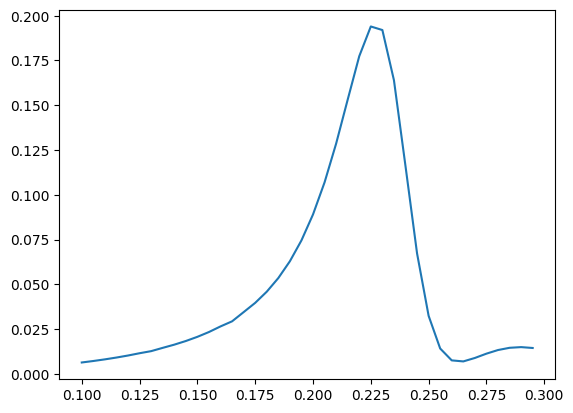

Var.value = 0.22500000000000012, .min = 0.0, .max = inf, .fit: False, .id: 


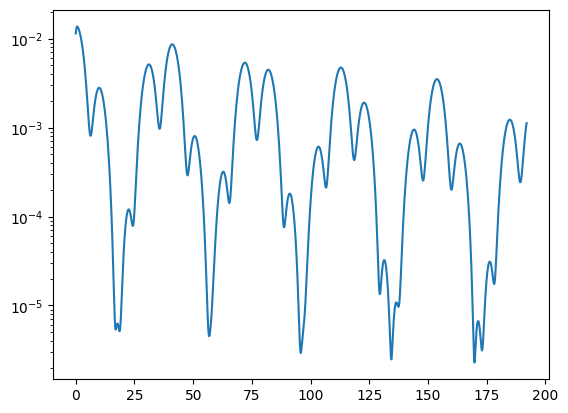

In [1]:
import nexus as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

beam = nx.Beam()
beam.LinearSigma()

# setup Fe layer on Silicon wafer
site = nx.Hyperfine(magnetic_field = nx.Var(33, min = 0, max = 40, fit = True, id = "magnetic field"))

site.SetRandomDistribution(target = "mag", type = "2Dsp", points = 401)

mat_Fe = nx.Material.Template(nx.lib.material.Fe)

mat_Fe.density = nx.Var(7.4, min = 7, max = 7.874, fit = True, id = "Fe density")

mat_Fe.hyperfine_sites = [site]

layer_Fe = nx.Layer(thickness = nx.Var(20, min = 10, max = 30, fit = True, id = "Fe thickness"),
                    roughness = nx.Var(0.6, min = 0, max = 1, fit = True, id = "Fe roughness"),
                    material = mat_Fe)

substrate = nx.Layer(thickness = nx.inf,
                     roughness = nx.Var(0.2, min = 0, max = 1, fit = True, id = "Si roughness"),
                     material = nx.Material.Template(nx.lib.material.Si))

sample = nx.Sample(layers = [layer_Fe, substrate],
                   geometry = "r",
                   length = 10,
                   roughness = "a")

# experiment

exp = nx.Experiment(beam = beam,
                           objects = [sample],
                           isotope = nx.lib.moessbauer.Fe57)

# relfectivity

angles = np.arange(0.1, 2, 0.005)

ref = nx.Reflectivity(experiment = exp,
                      sample = sample,
                      energy = nx.lib.energy.Fe57,
                      angles = angles,
                      resolution = 0.001)

ref_int = ref()*1.0e6
ref_int += np.random.poisson(2, len(ref_int))
ref_int = [x if x>=0 else 0 for x in ref_int]

plt.semilogy(angles, ref_int)
plt.show()

nx.data.Save("reflectivity.txt", [angles, ref_int])

# nuclear reflectivity

angles_nuc = np.arange(0.1, 0.3, 0.005)

nuc_ref = nx.NuclearReflectivity(experiment = exp,
                                 sample = sample,
                                 angles = angles_nuc,
                                 time_start = 10,
                                 time_stop  = 192,
                                 time_step = 0.2,
                                 max_detuning = 400)

nuc_ref_int = nuc_ref()

plt.plot(angles_nuc, nuc_ref_int)
plt.show()

nx.data.Save("nuclear_reflectivity.txt", [angles_nuc, nuc_ref_int*1e6])

# find maximum of nuc intensity

max_index = np.squeeze(argrelextrema(nuc_ref_int, np.greater))[0]

sample.angle = angles[max_index]

print(sample.angle)

# time spectrum

time_spectrum = nx.TimeSpectrum(experiment = exp,
                                time_length = 200,
                                time_step = 0.2,
                                max_detuning = 0,
                                bunch_spacing = 192.2, # PETRA III bunch spacing
                                id = "my time spectrum")

timeaxis, intensity = time_spectrum.Calculate()

plt.semilogy(timeaxis, intensity)
plt.show()

nx.data.Save("time_spectrum.txt", [timeaxis, intensity*1e6])